<a href="https://colab.research.google.com/github/nabiliqbal/coronavirus/blob/master/tests_corrected_no_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## New Rt code; this uses the binomial distribution to attempt to learn the number of infected cases, then uses that to construct an Rt value. 

### It does not take into account the noise in the Poisson time evolution; rather Rt is defined as the ratio of It over two successive times. In that sense this knows very little about time evolution. 

In [1]:
!pip install arviz==0.4.0
!pip install pymc3==3.8

     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 4.1MB 29.8MB/s 
     |████████████████████████████████| 286kB 44.5MB/s 
     |████████████████████████████████| 911kB 4.9MB/s 
     |████████████████████████████████| 1.5MB 13.5MB/s 
  Found existing installation: arviz 0.4.0
    Uninstalling arviz-0.4.0:
      Successfully uninstalled arviz-0.4.0
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


Now try to create the old Rt method like this. 




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [It]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 610.66it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


Text(0, 0.5, 'It')

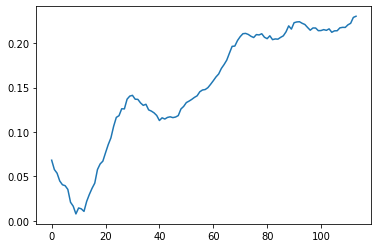

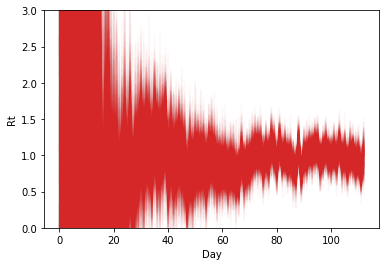

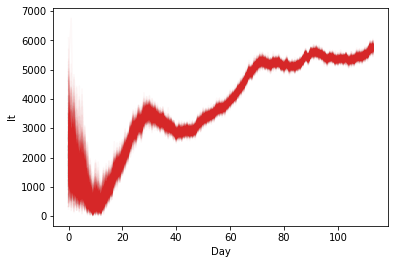

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

# disease parameters:
serial_interval = 7

# this is the total number
N = 25000

# first, let me generate the data; its just randomly distributed poisson

#deltaCases = np.random.poisson(10,size=50)

# days = 30;
#for i in range(days):
#  deltaCases[i-1] = m#ax(np.random.poisson(np.exp(i/2)),1)

# just hardcoding the data for now. 

deltaCases = np.array([3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 5.0, 9.0, 14.0, 20.0, 34.0, 46.0, 52.0, 68.0, 89.0, 111.0, 139.0, 169.0, 188.0, 215.0, 246.0, 290.0, 322.0, 345.0, 363.0, 389.0, 395.0, 409.0, 432.0, 439.0, 465.0, 486.0, 506.0, 512.0, 557.0, 590.0, 627.0, 657.0, 665.0, 683.0, 691.0, 733.0, 779.0, 814.0, 861.0, 893.0, 955.0, 982.0, 1062.0, 1151.0, 1178.0, 1259.0, 1336.0, 1417.0, 1501.0, 1576.0, 1664.0, 1610.0, 1646.0, 1697.0, 1791.0, 1800.0, 1884.0, 1990.0, 2107.0, 2298.0, 2408.0, 2508.0, 2522.0, 2645.0, 2668.0, 2767.0, 2802.0, 2864.0, 2995.0, 2998.0, 3061.0, 3106.0, 3247.0, 3351.0, 3428.0, 3435.0, 3406.0, 3490.0, 3533.0, 3572.0, 3522.0, 3514.0, 3522.0, 3555.0, 3626.0, 3686.0, 3712.0, 3757.0, 3827.0, 3723.0, 3650.0, 3554.0, 3478.0, 3355.0, 3331.0, 3279.0, 3145.0, 3092.0, 3014.0, 3059.0, 3054.0])
tests = np.array([44.0, 52.0, 56.0, 67.0, 74.0, 76.0, 85.0, 96.0, 122.0, 130.0, 139.0, 149.0, 190.0, 229.0, 303.0, 383.0, 472.0, 590.0, 719.0, 775.0, 888.0, 1038.0, 1189.0, 1308.0, 1452.0, 1589.0, 1705.0, 1953.0, 2118.0, 2294.0, 2443.0, 2652.0, 2846.0, 2977.0, 3147.0, 3294.0, 3516.0, 3765.0, 3999.0, 4268.0, 4536.0, 4805.0, 5151.0, 5388.0, 5613.0, 5726.0, 5848.0, 5835.0, 5823.0, 6051.0, 6117.0, 6391.0, 6535.0, 6875.0, 6980.0, 7311.0, 7817.0, 7972.0, 8401.0, 8697.0, 8988.0, 9270.0, 9536.0, 9703.0, 9155.0, 9101.0, 8990.0, 9119.0, 9151.0, 9281.0, 9598.0, 10004.0, 10892.0, 11477.0, 12073.0, 12223.0, 12616.0, 12750.0, 13140.0, 13560.0, 13968.0, 14380.0, 14699.0, 14951.0, 15189.0, 15723.0, 16093.0, 16117.0, 15652.0, 15782.0, 15650.0, 15781.0, 15938.0, 15840.0, 15899.0, 16179.0, 16568.0, 16702.0, 16983.0, 17342.0, 17540.0, 17781.0, 17363.0, 16891.0, 16745.0, 16263.0, 15680.0, 15336.0, 15056.0, 14446.0, 14014.0, 13556.0, 13360.0, 13261.0])
positivity = deltaCases/tests;
# shift them forward by 1.

#deltaCases_future = deltaCases[1:];
#deltaCases_past = deltaCases[:-1]
plt.plot(positivity)
plt.xlabel("Day")
plt.ylabel("Measured positivity")

Rt_model = pm.Model()

# okay, now try to build the model
with Rt_model:
  # Ignore this part; relevant for the older Rt
  #sigma = pm.Exponential('sigma',1/0.02)
  #Rt = pm.GaussianRandomWalk('Rt',sigma=sigma,shape=len(deltaCases_future))


  # Give It a uniform prior. (Works better if I make this a continuous variable.)
  It = pm.Uniform('It',lower = 1,upper = N, shape=len(deltaCases))

  # next, a distribution on the number of observed cases (there is no hypergeometric in pymc3! using binomial instead)
  Pt = pm.Binomial('Pt',n=tests,p=It/N,observed = deltaCases)

  # now create two arrays of the same length, offset by 1:
  It_past = pm.Deterministic('It_past',It[1:])
  It_future = pm.Deterministic('It_future',It[:-1])

  # now just take the ratio of one day in the future and one day in the past, putting in the factors to call ir Rt)
  Rt = pm.Deterministic('Rt',pm.math.log(It_future/It_past)*serial_interval+1)
  

with Rt_model:
  trace=pm.sample(2000,tune=1000)
  #pm.traceplot(trace,varnames=['It_past'])
  pm.summary(trace,varnames=['Rt'])

# plot the whole thing. 
plt.figure()
plt.plot(trace['Rt',::5].T,'C3',alpha=.03);
plt.ylim(top=3,bottom=0);
plt.xlabel("Day")
plt.ylabel("Rt")

# plot the learned number of new cases per day 
plt.figure()
plt.plot(trace['It',::5].T,'C3',alpha=.03);
plt.xlabel("Day")
plt.ylabel("It")


Its probably relevant to note that the learned number of cases is basically just positivity * N. This is not surprising at all. 

In [46]:
# generate a summary of the whole overall model
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
It[0],2182.767,1020.942,463.060,4112.565,13.612,10.390,5626.0,4828.0,5168.0,2612.0,1.0
It[1],1827.341,864.377,417.472,3429.530,13.088,9.704,4362.0,3968.0,3891.0,2108.0,1.0
It[2],1723.055,809.849,324.592,3225.328,10.331,8.041,6145.0,5072.0,5530.0,2717.0,1.0
It[3],1466.668,688.630,383.816,2794.092,10.225,7.551,4536.0,4160.0,4158.0,2716.0,1.0
It[4],1311.758,642.048,268.575,2452.616,8.802,6.990,5321.0,4220.0,4952.0,2205.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
Rt[108],1.002,0.152,0.728,1.288,0.002,0.001,5407.0,5352.0,5426.0,3277.0,1.0
Rt[109],0.905,0.154,0.618,1.207,0.002,0.001,5538.0,5512.0,5545.0,3048.0,1.0
Rt[110],0.950,0.152,0.672,1.234,0.002,0.001,6210.0,6120.0,6196.0,2893.0,1.0
Rt[111],0.793,0.154,0.516,1.092,0.002,0.001,6012.0,5848.0,6020.0,2995.0,1.0
